In [1]:
from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image
import pandas as pd
import torch
import os
from torchvision.transforms import CenterCrop, Resize, Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import torchvision.models
import torch.optim as optim
from tqdm import tqdm
import gc
import numpy as np

#### Now, let’s create an image transformation pipeline that’s required for EfficientNet v2

In [2]:
transformer = Compose([
    Resize((480,480)),
    CenterCrop(480),
    Normalize(mean =[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225] )
])

In [3]:
class DinoDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.key_frame = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
    
        img_name = os.path.join(self.root_dir, self.key_frame.iloc[idx,0])
        image = Image.open(img_name)
        image = ToTensor()(image)
        label = torch.tensor(self.key_frame.iloc[idx, 1])

        if self.transform: 
            image = self.transform(image)

        return image, label

In [5]:
key_frame = pd.read_csv("labels.csv") #importing the csv file with the labels of the key frames
train,test = train_test_split(key_frame, test_size = 0.2)  #splitting the data into train and test sets
train = pd.DataFrame(train) 
test = pd.DataFrame(test)

batch_size = 4
trainset = DinoDataset(root_dir = "captures", dataframe = train, transform = transformer)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size) 

testset = DinoDataset(root_dir = "captures", dataframe = test, transform = transformer)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size)

#### Let’s check out the images in one of the batches in the dataloader.

/opt/miniconda3/envs/dino/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow 

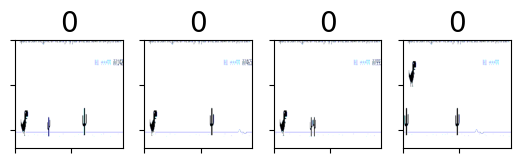

In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

for i in range(len(images)):
        ax = plt.subplot(2, 4, i + 1)
        image = (images[i].permute(1,2,0)*255.0).cpu()
        ax.set_title(labels[i].item(), fontsize=20)  # Setting the title of the subplot
        ax.set_xticklabels([])   # Removing the x-axis labels
        ax.set_yticklabels([])   # Removing the y-axis labels
        plt.imshow(image)        # Plotting the image

#### Creating the Model

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = torchvision.models.efficientnet_v2_s()
model.classifier = torch.nn.Linear(in_features = 1280, out_features = 2)

model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.009)

#### Training the Model

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [12:39<00:00,  7.75s/it]


[1] | loss: 0.021
Finished Training


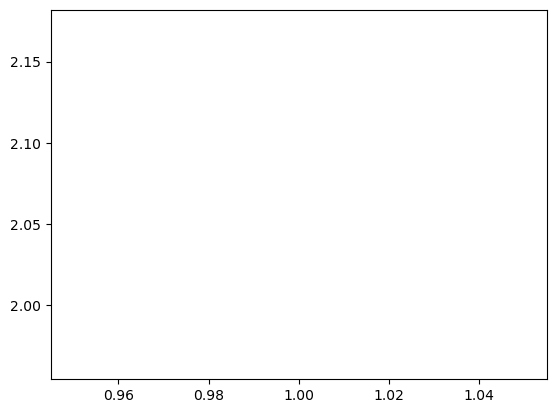

In [11]:
epochs = 15  # number of training passes over the mini batches
loss_container = [] # container to store the loss values after each epoch
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for data in tqdm(trainloader, position=0, leave=True):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    loss_container.append(running_loss)

    print(f'[{epoch + 1}] | loss: {running_loss / len(trainloader):.3f}')
    running_loss = 0.0

print('Finished Training')

# plot the loss curve
plt.plot(np.linspace(1, epochs, epochs).astype(int), loss_container)

# clean up the gpu memory 
gc.collect()
torch.cuda.empty_cache()

#### Save the model

In [13]:
PATH = 'efficientnet_s.pth'
torch.save(model.state_dict(), PATH)

#### Testing the Model Performance
Let’s load a new EfficientNet Model that uses the weights we saved in the last step.

In [14]:
saved_model = torchvision.models.efficientnet_v2_s()
saved_model.classifier = torch.nn.Linear(in_features = 1280, out_features = 2)
saved_model.load_state_dict(torch.load(PATH))
saved_model = saved_model.to(device)
saved_mode = saved_model.eval()

In [ ]:
correct = 0
total = 0
with torch.no_grad():
  for data in tqdm(testloader):
    images,labels = data
    images = images.to(device)
    labels = labels.to(device)

    outputs = saved_model(images)
    predicted = torch.softmax(outputs,dim = 1).argmax(dim = 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'\\n Accuracy of the network on the test images: {100 * correct // total} %')

 24%|███████████████████████▊                                                                           | 6/25 [00:10<00:33,  1.79s/it]